<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/32_Ultra_Pro_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%B4%D0%BB%D1%8F_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B8_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE_%D0%9F%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE_(%D0%A3%D0%BD%D0%B8%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%82%D0%B5%D1%82_%D0%B8%D1%81%D0%BA%D1%83%D1%81%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B8%D0%BD%D1%82%D0%B5%D0%BB%D0%BB%D0%B5%D0%BA%D1%82%D0%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Ultra pro

Макс 10 баллов

Найдите любую базу с аудио и напишите распознавание аудио:

1. Сделайте парсинг и нормализацию данных.
2. Разделите данные на обучающую и проверочную выборки
3. Сделайте классификацию 
4. Напишите ваши результаты и выводы



# Иссл.1. База взята с сайтаhttp://marsyas.info/downloads/datasets.html

## Загрузка данных и формирование выборки

In [ ]:
import librosa # Для параметризации аудио
import librosa.display # Для отображения аудиосигнала
import matplotlib.pyplot as plt
from google.colab import files # Для загрузки файлов 
import IPython.display as ipd # Для проигрывания аудио
import os
import numpy as np

from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input,  Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.utils import to_categorical #Для представления в формате one_hot_encoding

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!rm -R '/content/mini_genres' # Проверяем наличие папки texts. Если есть, удаляем ее

In [ ]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Базы/mini-genres.zip'



In [ ]:

genres = os.listdir('mini-genres') # получаем список папок в распакованной папке


In [ ]:

#Проверяем выгруженные папки
!ls mini-genres  
#И одну из папок
!ls mini-genres/jazz

classical  jazz  metal	pop  rock
jazz.00000.au  jazz.00002.au  jazz.00004.au  jazz.00006.au  jazz.00008.au
jazz.00001.au  jazz.00003.au  jazz.00005.au  jazz.00007.au  jazz.00009.au


In [ ]:
from librosa.feature.spectral import mfcc
#Функция параметризации аудио
def get_features(y,sr):
  #Получаем различные параметры аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) #Частота цветности (по усолчанию 12 баков цветности)
  mfcc = librosa.feature.mfcc(y=y, sr=sr) # Мел кепстральные коэффициенты (по усолчанию 20)

  rmse = np.mean(librosa.feature.mfcc(y=y)) #Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) # Среднее спектрального центроида
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) # Среднее ширины полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) #Среднее спектрального спада частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) # Cредняя частота пересечения нуля звукового временного ряда

  # Добавляем все параметры в дин список
  out = [] # создаем пустой список
  out.append(rmse) # добавляе среднеквадратиную амплитуду
  out.append(spec_cent) # добавляем спектральный центроид
  out.append(spec_bw) # добавляем ширину полосы частот
  out.append(rolloff) # добавляем спектральный спад частоты
  out.append(zcr) # добавляем пересечение нуля 

  # Дбавляем среднее всех мел кепстральных коэффициентов (20 значений)
  for e in mfcc:
    out.append(np.mean(e))

  # Добавляем среднее всех частот цветности (12 значений)
  for e in chroma_stft:
    out.append(np.mean(e))
  
  #Возвращаем получившийся список размерностью (37,)
  return out

In [ ]:
import time # подкючаем модуль time для подсчета времени на обработку одного жанра

# Формируем обучающую Выборку
# Создаем пустые листы
X_train = []
Y_train = []

#Запоминаем время старта формирования выборки
curr_time = time.time()

#Проходим по всем жанрам
for i in range(len(genres)):
  g = genres[i] # берем текущий жанр
  # Проходим по файлам папки текущего жанра
  for filename in os.listdir(f'./mini-genres/{g}'):
    # получаем имя песни
    songname = f'./mini-genres/{g}/{filename}'
    # загружаем в аудиосигнал
    # используем первые 30 секунд аудио
    y, sr = librosa.load(songname, mono = True, duration = 30) # y - массив данных временного ряда аудио, sr - частота дискретизации
    # Превращаем сигнал в параметризованные данные
    out = get_features(y,sr)

    # добавляем строку в X_train
    X_train.append(out)
    # добавляем в Y_train номер жанра в OHE
    Y_train.append(to_categorical(i, len(genres)))

  # Выводим инфо о готовности обработки базы
  print('Жанр ', g, ' готов  -->', round(time.time() - curr_time), 'c', sep='')
  curr_time = time.time()

# Превращаем обучающую выборку в numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)





Жанр classical готов  -->5c
Жанр metal готов  -->5c
Жанр rock готов  -->5c
Жанр jazz готов  -->5c
Жанр pop готов  -->5c


In [ ]:
# Создаем back up обучающей выборки 
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [ ]:
# Выводим номера классов , чтобы проверить, что все правильно заполнилось
# И номера классов идут последовательно крупными блоками
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4]


In [ ]:
# Выводим размеры обучающей выборки
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(50, 37)
(50, 5)
(50,)


In [ ]:
# Создаем scaler экземпляр класса StandardScaler() для нормировки данных
scaler = StandardScaler()
# Нормируем X_train
X_train = scaler.fit_transform(X_train)


In [ ]:
# Проверяем , что X_train нормировался
print(X_train[0])


[-1.06609634 -0.73830802 -0.83143066 -0.72130536 -0.50146053 -1.1551845
  0.58504454 -0.5410377   0.17731804 -0.33511099 -0.67358401 -0.38866553
 -0.72778639  0.13172976 -0.05772213  0.49467719 -0.64273088 -0.01987472
 -1.15618827  0.74011182  1.06908381  1.5031692   0.64540019  0.59962106
  0.13424225 -1.43501333 -1.65731967 -0.36209702  0.37795282 -1.02222184
  0.32765591 -1.30648125 -0.62652003 -0.41813429 -0.87449881  1.06710142
 -1.65509831]


In [ ]:
# Разделяем выборку на обучающую и проверочную (90% и 10%)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

In [ ]:
# Выводим размеры обучающей и проверочной выборки, для проверки
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(45, 37)
(45,)
(5, 37)
(5,)


## Полносвязная сеть relu + Dropout

Epoch 1/20
45/45 [==============================] - 1s 6ms/step - loss: 2.4195 - accuracy: 0.2000 - val_loss: 2.1970 - val_accuracy: 0.2000
Epoch 2/20
45/45 [==============================] - 0s 3ms/step - loss: 2.2393 - accuracy: 0.2000 - val_loss: 2.1588 - val_accuracy: 0.2000
Epoch 3/20
45/45 [==============================] - 0s 2ms/step - loss: 2.0939 - accuracy: 0.1778 - val_loss: 2.1241 - val_accuracy: 0.2000
Epoch 4/20
45/45 [==============================] - 0s 2ms/step - loss: 2.2489 - accuracy: 0.1556 - val_loss: 2.0903 - val_accuracy: 0.2000
Epoch 5/20
45/45 [==============================] - 0s 1ms/step - loss: 2.2731 - accuracy: 0.1556 - val_loss: 2.0550 - val_accuracy: 0.2000
Epoch 6/20
45/45 [==============================] - 0s 2ms/step - loss: 2.1853 - accuracy: 0.2222 - val_loss: 2.0225 - val_accuracy: 0.2000
Epoch 7/20
45/45 [==============================] - 0s 1ms/step - loss: 2.0802 - accuracy: 0.2444 - val_loss: 1.9865 - val_accuracy: 0.2000
Epoch 8/20
45/45 [==

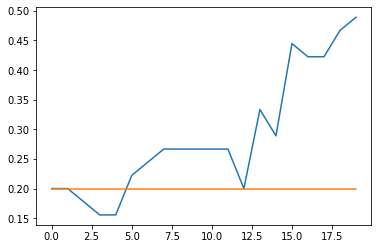

In [ ]:
indexes = range(0,37)

# Cоздаем полносвязную сеть
model_relu_D = Sequential()

model_relu_D.add(Dense(32, activation='relu', input_shape = (len(indexes),)))
model_relu_D.add(Dropout(0.25))
model_relu_D.add(Dense(5, activation='softmax'))

#Компилируем сеть 
model_relu_D.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_relu_D.fit(X_train[:,indexes],
                    y_train,
                    epochs=20,
                    batch_size=1,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/200
15/15 [==============================] - 3s 29ms/step - loss: 0.4122 - accuracy: 0.8556 - val_loss: 0.8638 - val_accuracy: 0.7800
Epoch 2/200
15/15 [==============================] - 0s 9ms/step - loss: 0.3654 - accuracy: 0.8744 - val_loss: 0.8628 - val_accuracy: 0.7600
Epoch 3/200
15/15 [==============================] - 0s 8ms/step - loss: 0.3625 - accuracy: 0.8689 - val_loss: 0.8771 - val_accuracy: 0.7600
Epoch 4/200
15/15 [==============================] - 0s 8ms/step - loss: 0.3181 - accuracy: 0.8956 - val_loss: 0.8795 - val_accuracy: 0.7700
Epoch 5/200
15/15 [==============================] - 0s 9ms/step - loss: 0.3430 - accuracy: 0.8778 - val_loss: 0.8725 - val_accuracy: 0.7600
Epoch 6/200
15/15 [==============================] - 0s 9ms/step - loss: 0.3651 - accuracy: 0.8667 - val_loss: 0.8719 - val_accuracy: 0.7700
Epoch 7/200
15/15 [==============================] - 0s 9ms/step - loss: 0.3801 - accuracy: 0.8622 - val_loss: 0.8697 - val_accuracy: 0.7700
Epoch 8/200


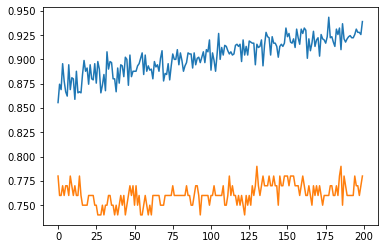

In [ ]:
#Компилируем сеть 
model_relu_D.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_relu_D.fit(X_train[:,indexes],
                    y_train,
                    epochs=200,
                    batch_size=64,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/300
15/15 [==============================] - 1s 18ms/step - loss: 0.2352 - accuracy: 0.9200 - val_loss: 0.9437 - val_accuracy: 0.7800
Epoch 2/300
15/15 [==============================] - 0s 6ms/step - loss: 0.2303 - accuracy: 0.9178 - val_loss: 0.9441 - val_accuracy: 0.7800
Epoch 3/300
15/15 [==============================] - 0s 5ms/step - loss: 0.2277 - accuracy: 0.9289 - val_loss: 0.9438 - val_accuracy: 0.7800
Epoch 4/300
15/15 [==============================] - 0s 6ms/step - loss: 0.2292 - accuracy: 0.9233 - val_loss: 0.9430 - val_accuracy: 0.7800
Epoch 5/300
15/15 [==============================] - 0s 5ms/step - loss: 0.2095 - accuracy: 0.9300 - val_loss: 0.9455 - val_accuracy: 0.7800
Epoch 6/300
15/15 [==============================] - 0s 5ms/step - loss: 0.1958 - accuracy: 0.9233 - val_loss: 0.9466 - val_accuracy: 0.7800
Epoch 7/300
15/15 [==============================] - 0s 6ms/step - loss: 0.2059 - accuracy: 0.9289 - val_loss: 0.9471 - val_accuracy: 0.7800
Epoch 8/300


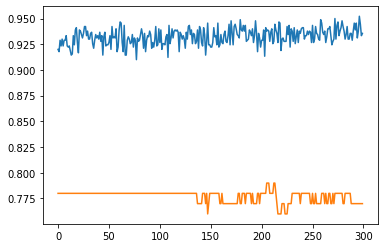

In [ ]:
#Компилируем сеть 
model_relu_D.compile(optimizer=RMSprop(learning_rate=1e-5),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_relu_D.fit(X_train[:,indexes],
                    y_train,
                    epochs=300,
                    batch_size=64,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/300
15/15 [==============================] - 1s 17ms/step - loss: 0.2039 - accuracy: 0.9278 - val_loss: 1.0034 - val_accuracy: 0.7600
Epoch 2/300
15/15 [==============================] - 0s 5ms/step - loss: 0.1920 - accuracy: 0.9422 - val_loss: 0.9911 - val_accuracy: 0.7700
Epoch 3/300
15/15 [==============================] - 0s 5ms/step - loss: 0.1873 - accuracy: 0.9300 - val_loss: 1.0048 - val_accuracy: 0.7800
Epoch 4/300
15/15 [==============================] - 0s 5ms/step - loss: 0.1685 - accuracy: 0.9389 - val_loss: 1.0075 - val_accuracy: 0.7800
Epoch 5/300
15/15 [==============================] - 0s 6ms/step - loss: 0.2002 - accuracy: 0.9378 - val_loss: 1.0215 - val_accuracy: 0.7800
Epoch 6/300
15/15 [==============================] - 0s 5ms/step - loss: 0.1894 - accuracy: 0.9322 - val_loss: 1.0206 - val_accuracy: 0.7800
Epoch 7/300
15/15 [==============================] - 0s 5ms/step - loss: 0.2069 - accuracy: 0.9278 - val_loss: 1.0066 - val_accuracy: 0.7800
Epoch 8/300


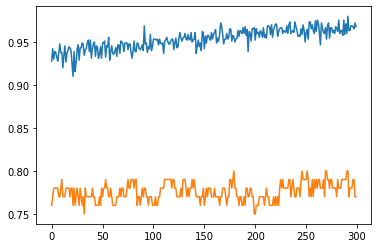

In [ ]:
#Компилируем сеть 
model_relu_D.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_relu_D.fit(X_train[:,indexes],
                    y_train,
                    epochs=300,
                    batch_size=64,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
model_relu_D.save('relu_d_77.h5')

Epoch 1/100
15/15 [==============================] - 2s 35ms/step - loss: 0.1152 - accuracy: 0.9600 - val_loss: 1.2115 - val_accuracy: 0.7600
Epoch 2/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0975 - accuracy: 0.9644 - val_loss: 1.2221 - val_accuracy: 0.7700
Epoch 3/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0935 - accuracy: 0.9722 - val_loss: 1.2177 - val_accuracy: 0.7700
Epoch 4/100
15/15 [==============================] - 0s 12ms/step - loss: 0.1119 - accuracy: 0.9644 - val_loss: 1.2119 - val_accuracy: 0.7800
Epoch 5/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0846 - accuracy: 0.9778 - val_loss: 1.2108 - val_accuracy: 0.7900
Epoch 6/100
15/15 [==============================] - 0s 10ms/step - loss: 0.1233 - accuracy: 0.9544 - val_loss: 1.2244 - val_accuracy: 0.8000
Epoch 7/100
15/15 [==============================] - 0s 12ms/step - loss: 0.1116 - accuracy: 0.9644 - val_loss: 1.2091 - val_accuracy: 0.7900
Epoch 

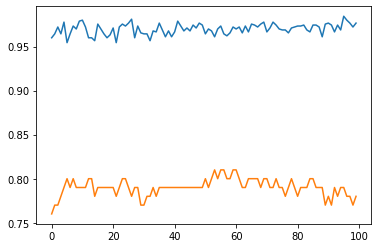

In [ ]:
#Компилируем сеть 
model_relu_D.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_relu_D.fit(X_train[:,indexes],
                    y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

# Иссл.2. База взята с сайта https://www.kaggle.com/uldisvalainis/audio-emotions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -R '/content/Emotions' # Проверяем наличие папки texts. Если есть, удаляем ее

In [ ]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Базы/Emotions.zip'



In [ ]:

emotions = os.listdir('Emotions') # получаем список папок в распакованной папке


In [ ]:

#Проверяем выгруженные папки
!ls Emotions  
#И одну из папок
!ls Emotions/Neutral

Angry  Disgusted  Fearful  Happy  Neutral  Sad	Suprised
03-01-01-01-01-01-02.wav   1035_MTI_NEU_XX.wav	1085_MTI_NEU_XX.wav
03-01-01-01-01-01-03.wav   1035_TAI_NEU_XX.wav	1085_TAI_NEU_XX.wav
03-01-01-01-01-01-04.wav   1035_TIE_NEU_XX.wav	1085_TIE_NEU_XX.wav
03-01-01-01-01-01-05.wav   1035_TSI_NEU_XX.wav	1085_TSI_NEU_XX.wav
03-01-01-01-01-01-06.wav   1035_WSI_NEU_XX.wav	1085_WSI_NEU_XX.wav
03-01-01-01-01-01-07.wav   1036_DFA_NEU_XX.wav	1086_DFA_NEU_XX.wav
03-01-01-01-01-01-08.wav   1036_IEO_NEU_XX.wav	1086_IEO_NEU_XX.wav
03-01-01-01-01-01-09.wav   1036_IOM_NEU_XX.wav	1086_IOM_NEU_XX.wav
03-01-01-01-01-01-10.wav   1036_ITH_NEU_XX.wav	1086_ITH_NEU_XX.wav
03-01-01-01-01-01-11.wav   1036_ITS_NEU_XX.wav	1086_ITS_NEU_XX.wav
03-01-01-01-01-01-12.wav   1036_IWL_NEU_XX.wav	1086_IWL_NEU_XX.wav
03-01-01-01-01-01-13.wav   1036_IWW_NEU_XX.wav	1086_IWW_NEU_XX.wav
03-01-01-01-01-01-14.wav   1036_MTI_NEU_XX.wav	1086_MTI_NEU_XX.wav
03-01-01-01-01-01-15.wav   1036_TAI_NEU_XX.wav	1086_TAI_NEU_XX.wav
03-01-

In [ ]:
from librosa.feature.spectral import mfcc
#Функция параметризации аудио
def get_features(y,sr):
  #Получаем различные параметры аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) #Частота цветности (по усолчанию 12 баков цветности)
  mfcc = librosa.feature.mfcc(y=y, sr=sr) # Мел кепстральные коэффициенты (по усолчанию 20)

  rmse = np.mean(librosa.feature.mfcc(y=y)) #Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) # Среднее спектрального центроида
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) # Среднее ширины полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) #Среднее спектрального спада частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) # Cредняя частота пересечения нуля звукового временного ряда

  # Добавляем все параметры в дин список
  out = [] # создаем пустой список
  out.append(rmse) # добавляе среднеквадратиную амплитуду
  out.append(spec_cent) # добавляем спектральный центроид
  out.append(spec_bw) # добавляем ширину полосы частот
  out.append(rolloff) # добавляем спектральный спад частоты
  out.append(zcr) # добавляем пересечение нуля 

  # Дбавляем среднее всех мел кепстральных коэффициентов (20 значений)
  for e in mfcc:
    out.append(np.mean(e))

  # Добавляем среднее всех частот цветности (12 значений)
  for e in chroma_stft:
    out.append(np.mean(e))
  
  #Возвращаем получившийся список размерностью (37,)
  return out

In [ ]:
import time # подкючаем модуль time для подсчета времени на обработку одного жанра

# Формируем обучающую Выборку
# Создаем пустые листы
X_train = []
Y_train = []

#Запоминаем время старта формирования выборки
curr_time = time.time()

#Проходим по всем жанрам
for i in range(len(emotions)):
  e = emotions[i] # берем текущую эмоцию
  # Проходим по файлам папки текущей эмоции
  for filename in os.listdir(f'./Emotions/{e}'):
    # получаем имя эмоции
    songname = f'./Emotions/{e}/{filename}'
    # загружаем в аудиосигнал
    # используем первые 30 секунд аудио
    y, sr = librosa.load(songname, mono = True, duration = 30) # y - массив данных временного ряда аудио, sr - частота дискретизации
    # Превращаем сигнал в параметризованные данные
    out = get_features(y,sr)

    # добавляем строку в X_train
    X_train.append(out)
    # добавляем в Y_train номер жанра в OHE
    Y_train.append(to_categorical(i, len(emotions)))

  # Выводим инфо о готовности обработки базы
  print('Тип эмоции ', e, ' готов  -->', round(time.time() - curr_time), 'c', sep='')
  curr_time = time.time()

# Превращаем обучающую выборку в numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)


Тип эмоции Neutral готов  -->234c
Тип эмоции Angry готов  -->308c


/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


Тип эмоции Sad готов  -->321c
Тип эмоции Suprised готов  -->78c
Тип эмоции Fearful готов  -->272c
Тип эмоции Disgusted готов  -->261c
Тип эмоции Happy готов  -->299c


In [ ]:
# Создаем back up обучающей выборки 
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [ ]:
# Выводим номера классов , чтобы проверить, что все правильно заполнилось
# И номера классов идут последовательно крупными блоками
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 ... 6 6 6]


In [ ]:
# Выводим размеры обучающей выборки
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(12798, 37)
(12798, 7)
(12798,)


In [ ]:
# Создаем scaler экземпляр класса StandardScaler() для нормировки данных
scaler = StandardScaler()
# Нормируем X_train
X_train = scaler.fit_transform(X_train)


In [ ]:
# Проверяем , что X_train нормировался
print(X_train[0])


[-0.65708882  0.09300807  0.86333719 -0.0386022  -0.46708228 -0.86009494
 -0.45395457 -0.05871044 -1.47493398  1.87946336 -0.1178578   0.07153232
 -0.29491203  0.26102249  0.35820162 -0.39091763  1.61574194 -1.27696903
  1.85390184  1.37373625  1.48706334 -1.88221756  1.90515933 -0.27975989
 -0.3684956  -0.71292994 -0.21328373 -1.7686047  -1.64454713 -1.07826387
  1.5480751   2.97130866 -0.78761817 -2.22578255 -2.04980339 -1.95489071
 -2.02551551]


In [ ]:
# Разделяем выборку на обучающую и проверочную (90% и 10%)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

In [ ]:
# Выводим размеры обучающей и проверочной выборки, для проверки
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(11518, 37)
(11518,)
(1280, 37)
(1280,)


### Dense + elu

Epoch 1/50
180/180 [==============================] - 1s 4ms/step - loss: 1.7103 - accuracy: 0.3173 - val_loss: 1.5213 - val_accuracy: 0.4359
Epoch 2/50
180/180 [==============================] - 1s 4ms/step - loss: 1.4996 - accuracy: 0.4234 - val_loss: 1.4012 - val_accuracy: 0.4602
Epoch 3/50
180/180 [==============================] - 1s 4ms/step - loss: 1.4110 - accuracy: 0.4578 - val_loss: 1.3321 - val_accuracy: 0.4828
Epoch 4/50
180/180 [==============================] - 1s 3ms/step - loss: 1.3463 - accuracy: 0.4795 - val_loss: 1.2838 - val_accuracy: 0.5039
Epoch 5/50
180/180 [==============================] - 1s 3ms/step - loss: 1.3050 - accuracy: 0.4931 - val_loss: 1.2484 - val_accuracy: 0.5117
Epoch 6/50
180/180 [==============================] - 1s 3ms/step - loss: 1.2664 - accuracy: 0.5048 - val_loss: 1.2251 - val_accuracy: 0.5234
Epoch 7/50
180/180 [==============================] - 1s 4ms/step - loss: 1.2372 - accuracy: 0.5175 - val_loss: 1.1940 - val_accuracy: 0.5297
Epoch 

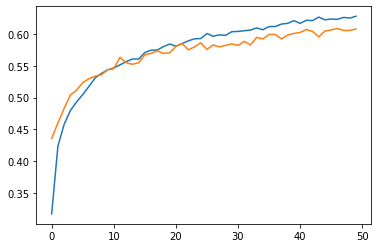

In [ ]:
indexes = range(0,37)

# Cоздаем полносвязную сеть
model_elu_D = Sequential()
model_elu_D.add(Dense(512, activation='elu', input_shape = (len(indexes),)))
model_elu_D.add(Dropout(0.25))
# model_elu_D.add(Dense(128, activation='elu'))

# model_elu_D.add(Dropout(0.2)
model_elu_D.add(Dense(64, activation='elu'))
# model_elu_D.add(Dropout(0.2)
model_elu_D.add(Dense(64, activation='elu'))

model_elu_D.add(Dense(7, activation='softmax'))

#Компилируем сеть 
model_elu_D.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_elu_D.fit(X_train[:,indexes],
                    y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/100
180/180 [==============================] - 1s 4ms/step - loss: 0.9490 - accuracy: 0.6266 - val_loss: 0.9660 - val_accuracy: 0.6109
Epoch 2/100
180/180 [==============================] - 1s 4ms/step - loss: 0.9425 - accuracy: 0.6327 - val_loss: 0.9729 - val_accuracy: 0.6086
Epoch 3/100
180/180 [==============================] - 1s 3ms/step - loss: 0.9431 - accuracy: 0.6309 - val_loss: 0.9668 - val_accuracy: 0.6109
Epoch 4/100
180/180 [==============================] - 1s 4ms/step - loss: 0.9379 - accuracy: 0.6320 - val_loss: 0.9660 - val_accuracy: 0.6148
Epoch 5/100
180/180 [==============================] - 1s 3ms/step - loss: 0.9358 - accuracy: 0.6336 - val_loss: 0.9602 - val_accuracy: 0.6094
Epoch 6/100
180/180 [==============================] - 1s 4ms/step - loss: 0.9354 - accuracy: 0.6349 - val_loss: 0.9652 - val_accuracy: 0.6125
Epoch 7/100
180/180 [==============================] - 1s 4ms/step - loss: 0.9345 - accuracy: 0.6327 - val_loss: 0.9584 - val_accuracy: 0.6102

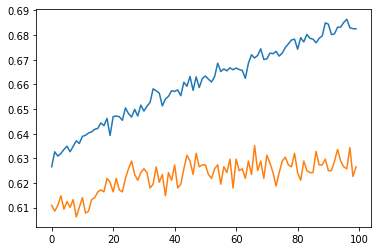

In [ ]:
#Дообучим сеть с learning_rate=1e-4
model_elu_D.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_elu_D.fit(X_train[:,indexes],
                    y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/150
180/180 [==============================] - 1s 5ms/step - loss: 0.8035 - accuracy: 0.6861 - val_loss: 0.9279 - val_accuracy: 0.6297
Epoch 2/150
180/180 [==============================] - 1s 4ms/step - loss: 0.7995 - accuracy: 0.6896 - val_loss: 0.9266 - val_accuracy: 0.6313
Epoch 3/150
180/180 [==============================] - 1s 3ms/step - loss: 0.8001 - accuracy: 0.6866 - val_loss: 0.9266 - val_accuracy: 0.6297
Epoch 4/150
180/180 [==============================] - 1s 4ms/step - loss: 0.7946 - accuracy: 0.6918 - val_loss: 0.9262 - val_accuracy: 0.6305
Epoch 5/150
180/180 [==============================] - 1s 3ms/step - loss: 0.7971 - accuracy: 0.6927 - val_loss: 0.9260 - val_accuracy: 0.6336
Epoch 6/150
180/180 [==============================] - 1s 4ms/step - loss: 0.7998 - accuracy: 0.6872 - val_loss: 0.9260 - val_accuracy: 0.6320
Epoch 7/150
180/180 [==============================] - 1s 4ms/step - loss: 0.7973 - accuracy: 0.6907 - val_loss: 0.9256 - val_accuracy: 0.6359

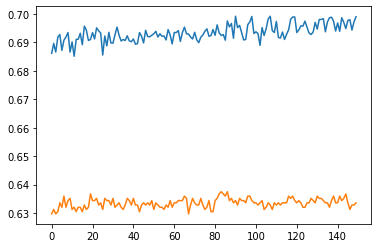

In [ ]:
#переомпилируем сеть с learning_rate=1e-5
model_elu_D.compile(optimizer=RMSprop(learning_rate=1e-5),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_elu_D.fit(X_train[:,indexes],
                    y_train,
                    epochs=150,
                    batch_size=64,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

### Dense + relu

Epoch 1/50
180/180 [==============================] - 2s 7ms/step - loss: 1.6915 - accuracy: 0.3304 - val_loss: 1.4725 - val_accuracy: 0.4359
Epoch 2/50
180/180 [==============================] - 1s 6ms/step - loss: 1.4138 - accuracy: 0.4504 - val_loss: 1.2957 - val_accuracy: 0.4984
Epoch 3/50
180/180 [==============================] - 1s 6ms/step - loss: 1.2884 - accuracy: 0.5006 - val_loss: 1.2094 - val_accuracy: 0.5320
Epoch 4/50
180/180 [==============================] - 1s 6ms/step - loss: 1.2184 - accuracy: 0.5244 - val_loss: 1.1574 - val_accuracy: 0.5375
Epoch 5/50
180/180 [==============================] - 1s 6ms/step - loss: 1.1648 - accuracy: 0.5453 - val_loss: 1.1276 - val_accuracy: 0.5422
Epoch 6/50
180/180 [==============================] - 1s 6ms/step - loss: 1.1335 - accuracy: 0.5526 - val_loss: 1.0970 - val_accuracy: 0.5539
Epoch 7/50
180/180 [==============================] - 1s 6ms/step - loss: 1.1084 - accuracy: 0.5654 - val_loss: 1.0740 - val_accuracy: 0.5633
Epoch 

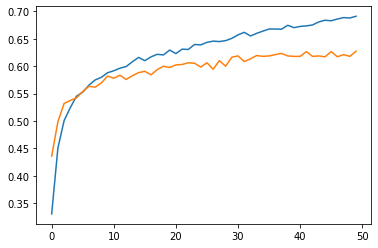

In [ ]:

indexes = range(0,37)

# Cоздаем полносвязную сеть
model_relu_D2 = Sequential()
model_relu_D2.add(Dense(512, activation='relu', input_shape = (len(indexes),)))
model_relu_D2.add(Dropout(0.25))
model_relu_D2.add(Dense(256, activation='relu'))
model_relu_D2.add(Dense(128, activation='relu'))
model_relu_D2.add(Dense(7, activation='softmax'))

#Компилируем сеть 
model_relu_D2.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_relu_D2.fit(X_train[:,indexes],
                    y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()



### Dense + linear

Epoch 1/50
180/180 [==============================] - 2s 7ms/step - loss: 1.6814 - accuracy: 0.3515 - val_loss: 1.4466 - val_accuracy: 0.4602
Epoch 2/50
180/180 [==============================] - 1s 6ms/step - loss: 1.3969 - accuracy: 0.4563 - val_loss: 1.2795 - val_accuracy: 0.5000
Epoch 3/50
180/180 [==============================] - 1s 6ms/step - loss: 1.2830 - accuracy: 0.4984 - val_loss: 1.1972 - val_accuracy: 0.5289
Epoch 4/50
180/180 [==============================] - 1s 6ms/step - loss: 1.2174 - accuracy: 0.5253 - val_loss: 1.1492 - val_accuracy: 0.5531
Epoch 5/50
180/180 [==============================] - 1s 6ms/step - loss: 1.1663 - accuracy: 0.5437 - val_loss: 1.1162 - val_accuracy: 0.5602
Epoch 6/50
180/180 [==============================] - 1s 6ms/step - loss: 1.1332 - accuracy: 0.5557 - val_loss: 1.0870 - val_accuracy: 0.5797
Epoch 7/50
180/180 [==============================] - 1s 6ms/step - loss: 1.1021 - accuracy: 0.5669 - val_loss: 1.0680 - val_accuracy: 0.5781
Epoch 

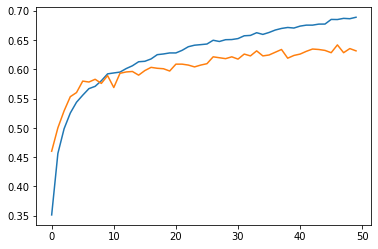

In [ ]:

indexes = range(0,37)

# Cоздаем полносвязную сеть
model_linear = Sequential()
model_linear.add(Dense(512, activation='relu', input_shape = (len(indexes),)))
model_linear.add(Dropout(0.25))
model_linear.add(Dense(256, activation='relu'))
model_linear.add(Dense(128, activation='relu'))
model_linear.add(Dense(7, activation='softmax'))

#Компилируем сеть 
model_linear.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_linear.fit(X_train[:,indexes],
                    y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()



#Результаты и выводы

В исследовании 1 была взята небольшая база музыки , разные жанры были определены с точностью 80%. В исследовании 2 исользовалась довольно объемная база типов эмоций , здесь удалось достичь 63 % точности , изменение гиперпараметров не дало улучшения результата, предположительно требуется поработать с данными , возмоэно применить другие способы нормализации. 